In [1]:
#%matplotlib inline
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from lib import get_epoch_df

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pickle
from scipy.stats import binom
import pandas as pd

In [3]:
from MinaClient import Client
from mina_schemas import mina_explorer_schema
from sgqlc.operation import Operation

MINA_EXPLORER_ENDPOINT = "https://graphql.minaexplorer.com/"
mina_explorer_client = Client(endpoint=MINA_EXPLORER_ENDPOINT)

# Minaexplorer perfromance analysis



```get_epoch_df``` is the python port of the ```batch-check-witness``` part from zkvalidator's excellet [mina-vrf-rs](https://github.com/zkvalidator/mina-vrf-rs) tool. It also adds a couple of additional things like "next super charged block" times. Everything is saved as pandas Dataframes to enrich it later with additional data and play around with it.


I used mina-vrf-rs to generate the ```check``` files for the provided minaexplorer wittness data (up and including epoch 17) from https://docs.minaexplorer.com/v1.0/minaexplorer/performance-history. Thanks again to https://minaexplorer.com/ for all the contributions!


!!! this is very much work in progress - and might not be 100% correct !!! The idea is more to enrich the dfs with additional data to explore it much further! If there is any interest I will clean up get_epoch_df and push it!

## run and extract the data!

In [39]:
minaexplorer_key = "B62qpge4uMq4Vv5Rvc8Gw9qSquUYd6xoW1pz7HQkMSHm6h1o7pvLPAN"

dfs = []
results = []

start_epoch = 0
end_epoch = 18

for epoch in range(start_epoch, end_epoch):
    res = get_epoch_df(epoch, block_producer_key=minaexplorer_key)
    print(f"epoch {epoch} - took {res['total_time']}")
    results.append(res)

pickle.dump(results, open(f"{MINA_BP_KEY}_perfromance_results.p", "wb"))

epoch 0 - took 9.765044666999529
epoch 1 - took 11.124484166000912
epoch 2 - took 13.40275954200115
epoch 3 - took 13.696586000000025
epoch 4 - took 14.174995999999737
epoch 5 - took 22.49327416699998
epoch 6 - took 16.878061125000386
epoch 7 - took 28.50294762500016
epoch 8 - took 34.20788262499991
epoch 9 - took 41.257336582999415
epoch 10 - took 47.27077233300042
epoch 11 - took 48.43517179099945
epoch 12 - took 57.99997079199966
epoch 13 - took 59.62975962500059
epoch 14 - took 68.14214533300037
epoch 15 - took 82.40015787500124
epoch 16 - took 87.09291095800108
epoch 17 - took 91.96814174999963


### read back

In [6]:
results = pickle.load(open(f"{MINA_BP_KEY}_perfromance_results.p", "rb"))

df = pd.concat([x["df"] for x in results])
df.reset_index(inplace=True, drop=True)

## data quick look

In [8]:
df.head()

,epoch,slot,global_slot,block,winner_exists,saw_my_producer,bp_won,block_time,received_time,winner_pk,super_charged,block_height_equal,too_late,min_bt,min_bt_minutes,outcome,next_block_in
0,0,47,47,38,True,True,False,[0 days 00:00:42.260000],2021-03-17 02:21:31.512000+00:00,B62qn71s63yywMUCcFhP4iCata7HpgyrvmGjpKa1D9544v...,False,True,False,0 days 00:00:42.260000,0.70,LOST,NaN
1,0,48,48,39,True,True,True,[0 days 00:00:42.441000],2021-03-17 02:24:42.441000+00:00,B62qmvmCN8qzDBKAD6M89hvGQeundPcDHhq5DrU57orGGK...,False,True,False,0 days 00:00:42.441000,0.70,WON,NaN
2,0,91,91,68,True,True,False,[0 days 00:00:45.622000],2021-03-17 04:33:39.927000+00:00,B62qmsYXFNNE565yv7bEMPsPnpRCsMErf7J2v5jMnuKQ1j...,False,True,False,0 days 00:00:45.622000,0.75,LOST,NaN
3,0,196,196,139,True,True,True,[0 days 00:00:48.421000],2021-03-17 09:48:48.421000+00:00,B62qmsYXFNNE565yv7bEMPsPnpRCsMErf7J2v5jMnuKQ1j...,False,True,False,0 days 00:00:48.421000,0.80,WON,NaN
4,0,228,228,160,True,True,False,[0 days 00:00:45.656000],2021-03-17 11:25:35.479000+00:00,B62qmsYXFNNE565yv7bEMPsPnpRCsMErf7J2v5jMnuKQ1j...,False,True,False,0 days 00:00:45.656000,0.75,LOST,NaN


In [44]:
# next_block_in is NaN since the epoch is already fully done...
# block_time is a list of all produced blocks for the slot
# outcome, saw_my_producer etc is aligned to how it's called in the rust version

In [42]:
df.head(n=1).T

,0
epoch,0
slot,47
global_slot,47
block,38
winner_exists,True
saw_my_producer,True
bp_won,False
block_time,[0 days 00:00:42.260000]
received_time,2021-03-17 02:21:31.512000+00:00
winner_pk,B62qn71s63yywMUCcFhP4iCata7HpgyrvmGjpKa1D9544v...


In [45]:
df.shape

(3765, 17)

In [51]:
# from here we have access to all the data

In [52]:
df.groupby('epoch').size()

epoch
0     142
1     127
2     149
3     167
4     157
5     163
6     149
7     193
8     205
9     217
10    236
11    223
12    266
13    250
14    279
15    289
16    287
17    266
dtype: int64

## outcome per epoch

<AxesSubplot:xlabel='epoch', ylabel='outcome_count'>

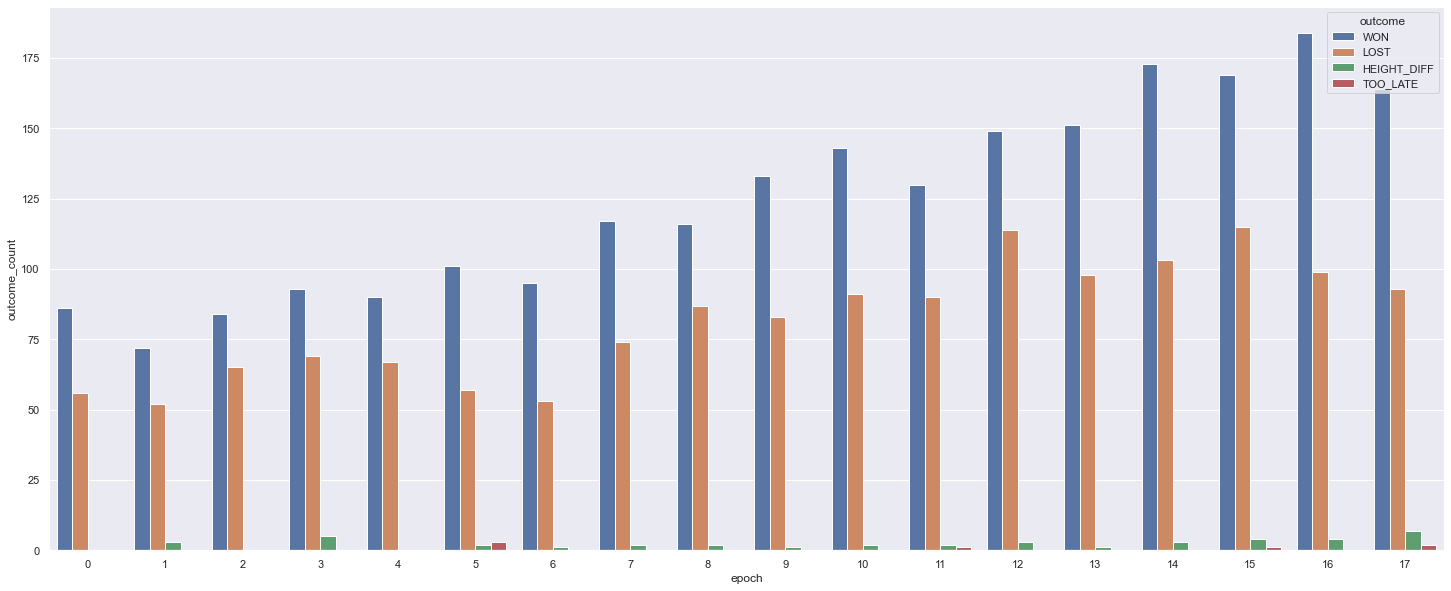

In [53]:
sns.set(rc={"figure.figsize": (25, 10)})


counts_df = (
    df.groupby("epoch")
    .outcome.value_counts()
    .to_frame()
    .rename(columns={"outcome": "outcome_count"})
    .reset_index()
)

sns.barplot(x="epoch", y="outcome_count", data=counts_df, hue="outcome")

## outcome grouped by super_charged

In [54]:
df.groupby(["epoch", "super_charged"]).outcome.value_counts()

epoch  super_charged  outcome    
0      False          WON             86
                      LOST            56
1      False          WON             72
                      LOST            52
                      HEIGHT_DIFF      3
2      False          WON             84
                      LOST            65
3      False          WON             93
                      LOST            69
                      HEIGHT_DIFF      5
4      False          WON             89
                      LOST            67
       True           WON              1
5      False          WON            100
                      LOST            57
                      TOO_LATE         3
                      HEIGHT_DIFF      2
       True           WON              1
6      False          WON             94
                      LOST            53
                      HEIGHT_DIFF      1
       True           WON              1
7      False          WON             98
                      L

## slot luck
try to visualize "slot luck"

epoch 0 - expected 133 slots - got 142... 
epoch 1 - expected 133 slots - got 127... 
epoch 2 - expected 152 slots - got 149... 
epoch 3 - expected 156 slots - got 167... 
epoch 4 - expected 158 slots - got 157... 
epoch 5 - expected 161 slots - got 163... 
epoch 6 - expected 163 slots - got 149... 
epoch 7 - expected 187 slots - got 193... 
epoch 8 - expected 203 slots - got 205... 
epoch 9 - expected 227 slots - got 217... 
epoch 10 - expected 247 slots - got 236... 
epoch 11 - expected 230 slots - got 223... 
epoch 12 - expected 261 slots - got 266... 
epoch 13 - expected 264 slots - got 250... 
epoch 14 - expected 278 slots - got 279... 
epoch 15 - expected 284 slots - got 289... 
epoch 16 - expected 287 slots - got 287... 
epoch 17 - expected 296 slots - got 266... 


<Figure size 1800x720 with 0 Axes>

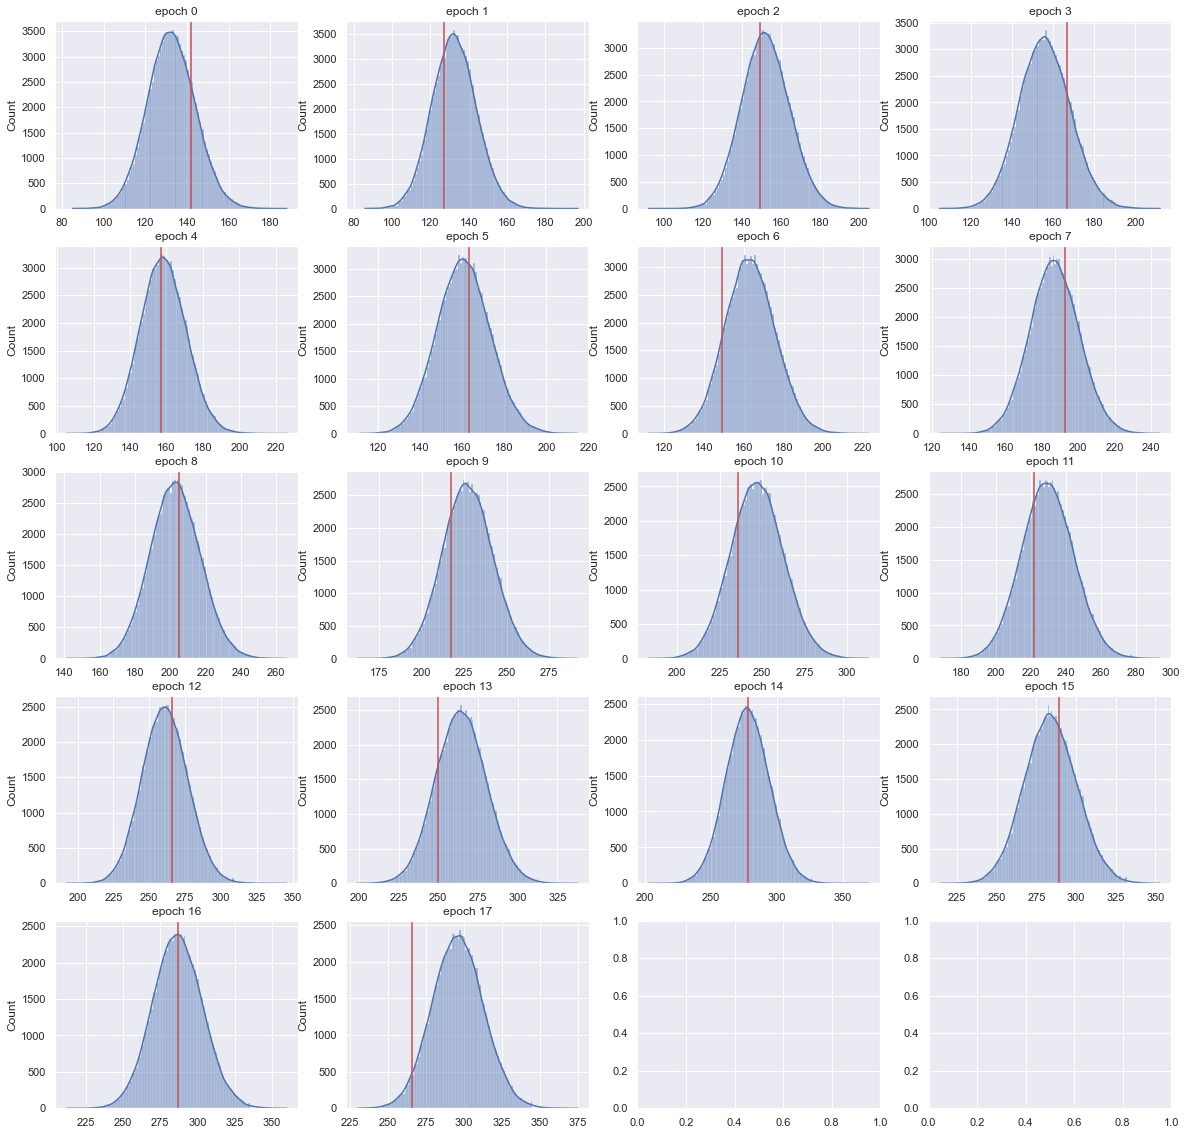

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

In [55]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))

SLOTS_PER_EPOCH = 7140

def get_slot_win_perc(stake, total_currency):
    return (1 - ((1 / 4) ** (stake / total_currency)))

epoch_data = []
for epoch, ax in zip(range(0,18), axes.flat):
    total_currency = results[epoch]['epoch_data']['total_currency']
    total_staking_balance = results[epoch]['stakes_df'].balance.sum()
    
    slot_win_pct = get_slot_win_perc(
        total_staking_balance, total_currency
    )    
    expected_blocks_value = slot_win_pct * SLOTS_PER_EPOCH 
    
    won_blocks = df[(df.epoch == epoch) & (df.outcome == 'WON')].block.count()
    slots_won = df[(df.epoch == epoch)].slot.nunique()
    
    data = binom.rvs(n=SLOTS_PER_EPOCH, p=slot_win_pct, size=100000)
    
    k = np.arange(int(expected_blocks_value - 50), int(expected_blocks_value) + 50, 1)
    
    plt.figure(epoch)
    
    sns.histplot(data, kde=True, bins=k, ax=ax)
    ax.axvline(df[(df.epoch == epoch)].block.nunique(), 0, 1, color="r")
    ax.set_title(f"epoch {epoch}")
    
    epoch_data.append({
        'epoch': epoch,
        'expected_slots': expected_blocks_value,
        'expected_slots_binom': binom(SLOTS_PER_EPOCH, slot_win_pct).expect(),
        'slot_win_pct': slot_win_pct,
        'won_slots': slots_won,
        'won_blocks': won_blocks,
        'orphan_rate': 1 - (won_blocks/slots_won)
    })
    
    print(f"epoch {epoch} - expected {round(expected_blocks_value)} slots - got {slots_won}... ")
    

plt.show()

In [57]:
# what are the unluckiest/luckiest epochs

epoch_slots_df = pd.DataFrame(epoch_data)

epoch_slots_df["cdf"] = epoch_slots_df.apply(
    lambda row: binom.cdf(row["won_slots"], SLOTS_PER_EPOCH, row["slot_win_pct"]),
    axis=1,
)
epoch_slots_df

,epoch,expected_slots,expected_slots_binom,slot_win_pct,won_slots,won_blocks,orphan_rate,cdf
0,0,132.508512,132.508512,0.018559,142,86,0.394366,0.810456
1,1,132.508512,132.508512,0.018559,127,72,0.433071,0.334409
2,2,151.940431,151.940431,0.021280,149,84,0.436242,0.425627
3,3,156.031433,156.031433,0.021853,167,93,0.443114,0.823889
4,4,158.280451,158.280451,0.022168,157,90,0.426752,0.480077
5,5,160.621849,160.621849,0.022496,163,101,0.380368,0.595495
6,6,163.234044,163.234044,0.022862,149,95,0.362416,0.137832
7,7,187.115622,187.115622,0.026207,193,117,0.393782,0.685105
8,8,202.791630,202.791630,0.028402,205,116,0.434146,0.580711
9,9,226.909151,226.909151,0.031780,217,133,0.387097,0.264837


In [58]:
epoch_slots_df.cdf.describe()

count    18.000000
mean      0.460731
std       0.227573
min       0.037816
25%       0.282230
50%       0.500544
75%       0.625100
max       0.823889
Name: cdf, dtype: float64

(0.0, 1.0)

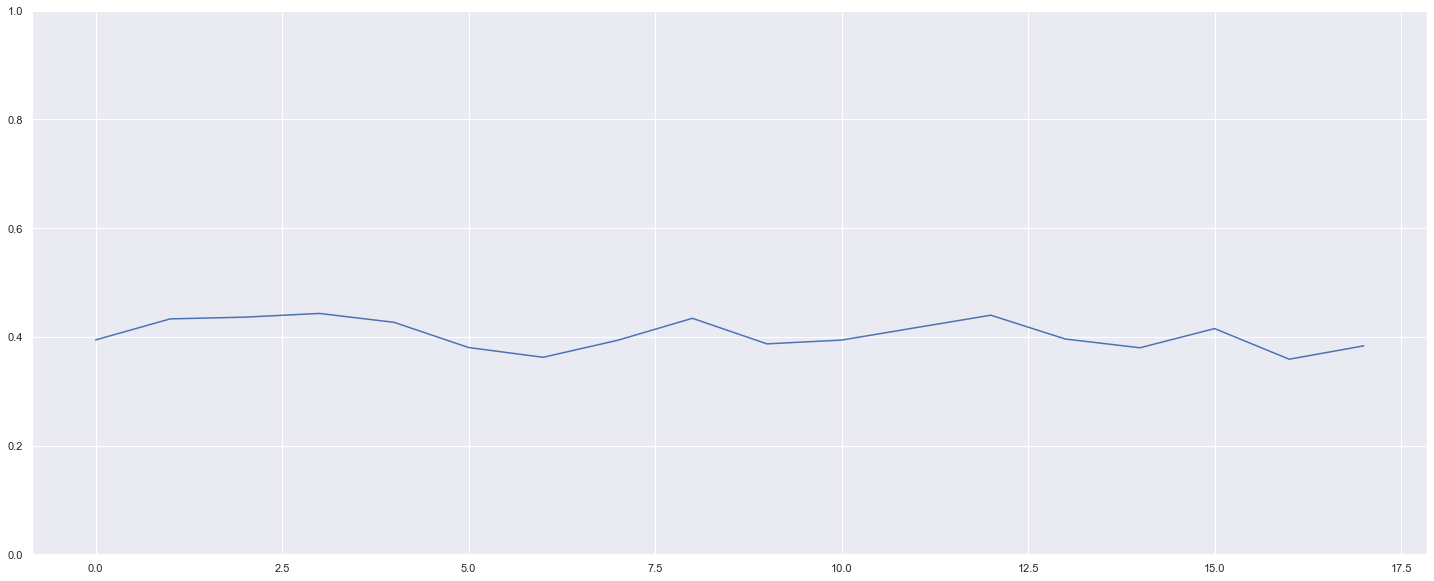

In [59]:
f = epoch_slots_df.orphan_rate.plot()
f.set_ylim(0,1)

## more plots

In [60]:
# probably overcomplicated but getting "beginning of epoch times"

epoch_start_time_data = []

for epoch in range(0, 18):

    consensus_state = mina_explorer_schema.BlockProtocolStateConsensusStateQueryInput(
        epoch=epoch
    )
    protocol_state = mina_explorer_schema.BlockProtocolStateQueryInput(
        consensus_state=consensus_state
    )

    op = Operation(mina_explorer_schema.Query)
    query = mina_explorer_schema.BlockQueryInput(protocol_state=protocol_state,)
    # needs to be sorted - but this works accidentally for now
    blocks = op.blocks(query=query, limit=1)
    blocks.block_height()
    blocks.date_time()

    res = mina_explorer_client.send_any_query(op)

    tmp = res["data"]["blocks"][0]
    tmp["epoch"] = epoch
    epoch_start_time_data.append(tmp)

epoch_start_df = pd.DataFrame(epoch_start_time_data)
epoch_start_df.dateTime = pd.to_datetime(epoch_start_df.dateTime)

epoch_to_start_time_dict = (
    epoch_start_df
    .set_index("epoch")
    .to_dict()["dateTime"]
)

Text(0.5, 1.0, 'hourly mean block time - red vertical lines are beginning of epoch')

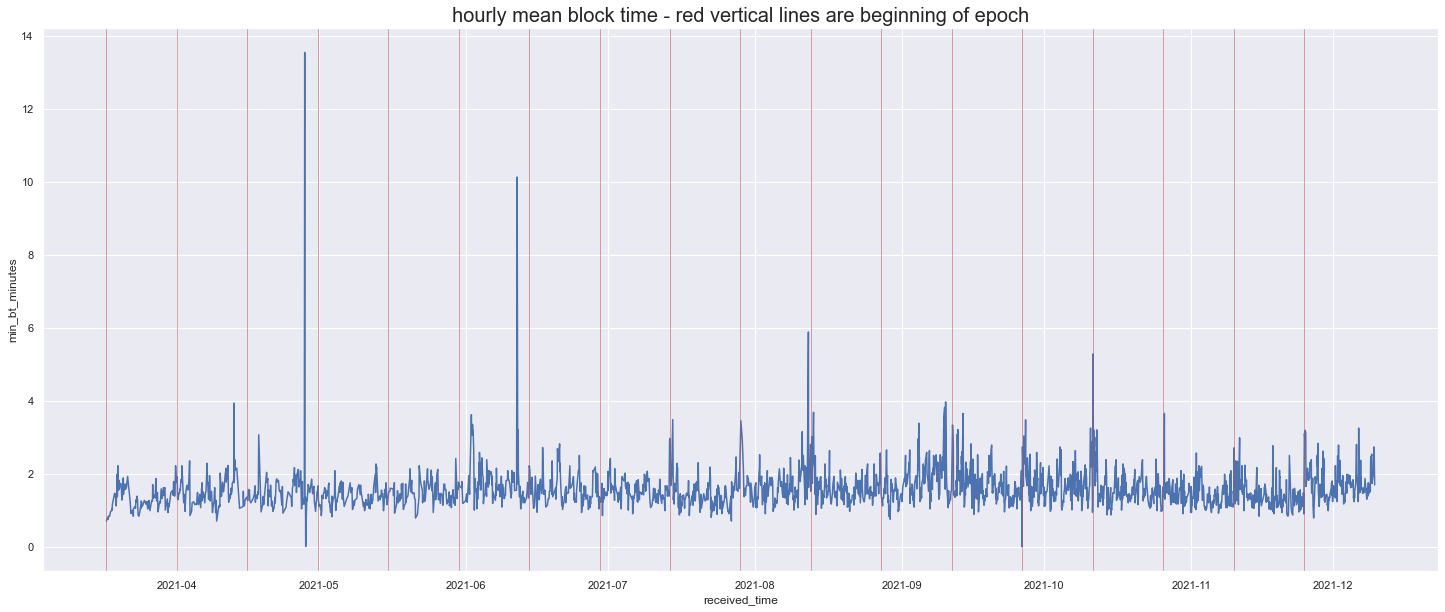

In [63]:
sns.set(rc={"figure.figsize": (25, 10)})

tmp_df = df.set_index("received_time", drop=False)
rt_df = tmp_df.resample("H").agg({"min_bt_minutes": "mean"}).reset_index()

f, ax = plt.subplots()
sns.lineplot(data=rt_df, x="received_time", y="min_bt_minutes")
for k, v in epoch_to_start_time_dict.items():
    ax.axvline(v, 0, 1, color="r", linewidth=0.5)
ax.set_title('hourly mean block time - red vertical lines are beginning of epoch', fontsize=20)

Text(0.5, 1.0, 'hourly mean block time - red vertical lines are beginning of epoch')

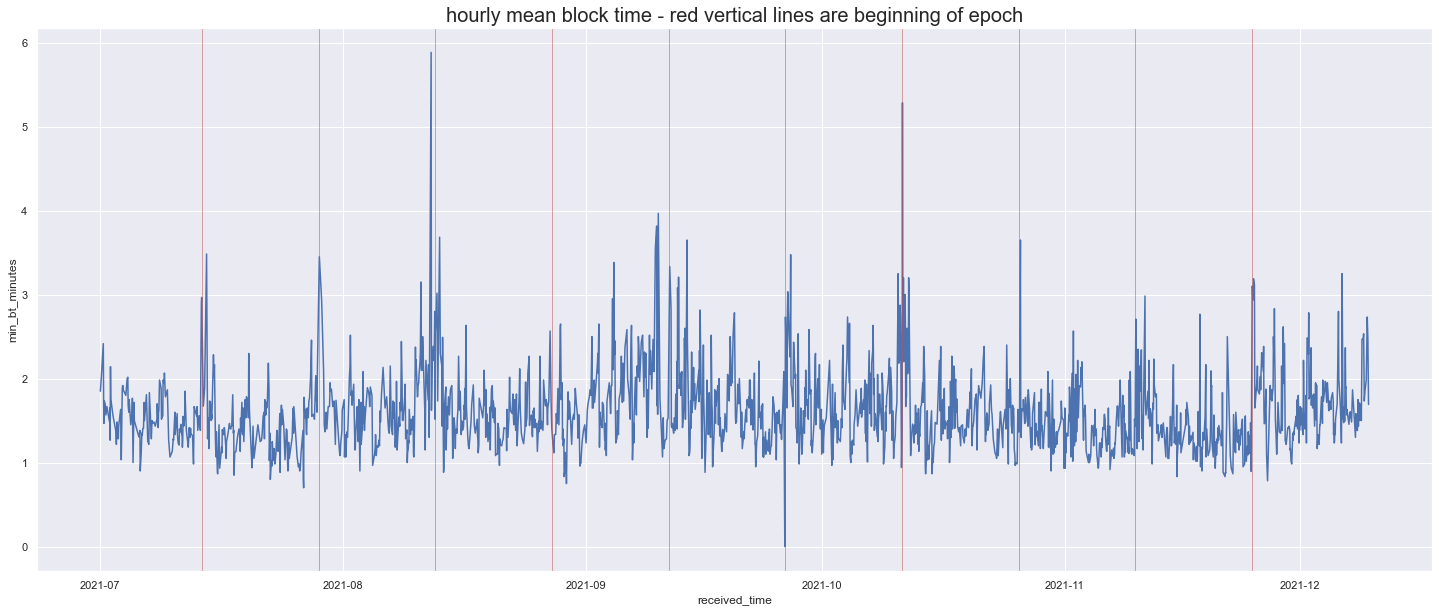

In [64]:
f, ax = plt.subplots()
data_slice = rt_df[rt_df.received_time > "2021-07-01"]
sns.lineplot(data=data_slice, x="received_time", y="min_bt_minutes")
for k, v in epoch_to_start_time_dict.items():
    if k < 8:
        continue
    ax.axvline(v, 0, 1, color="r", linewidth=0.5)
ax.set_title('hourly mean block time - red vertical lines are beginning of epoch', fontsize=20)

In [67]:
# idea was to show the errors but minaexplorer has so few of them o_O

Text(0.5, 1.0, '12hourly max block time by outcome')

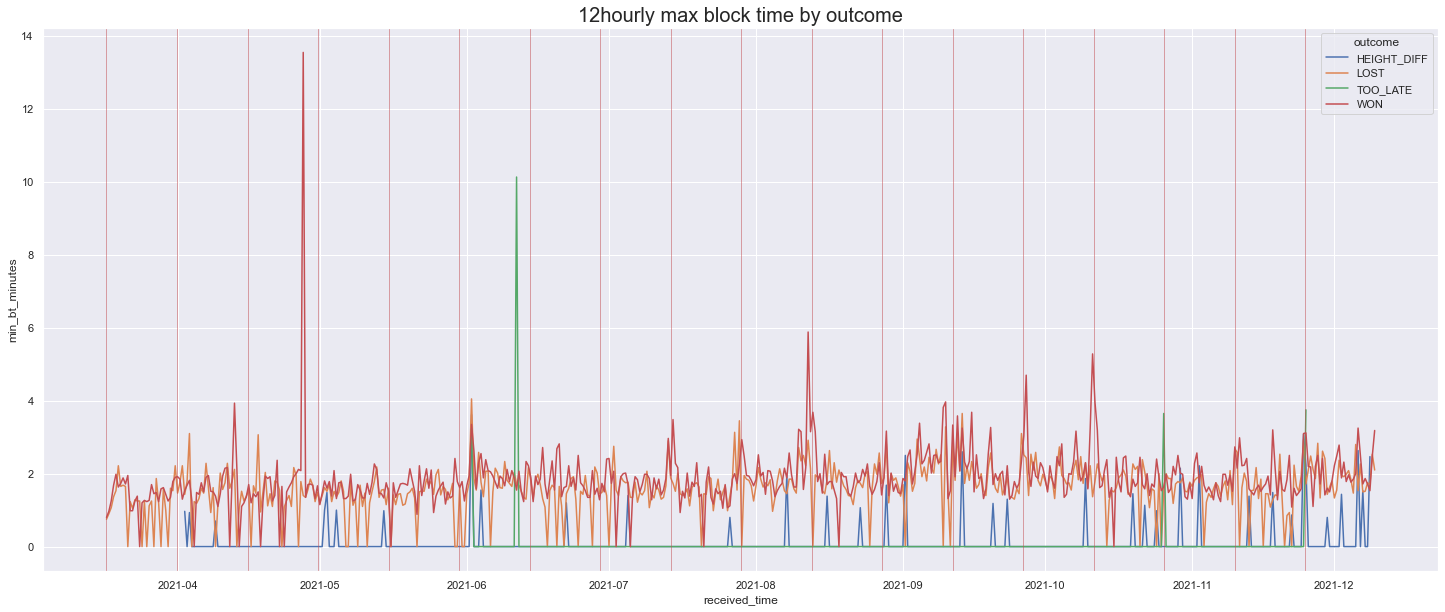

In [68]:
sns.set(rc={"figure.figsize": (25, 10)})

rt_df = tmp_df.groupby('outcome').resample('12H')['min_bt_minutes'].max().reset_index()
rt_df.fillna(0, inplace=True)

f, ax = plt.subplots()
sns.lineplot(data=rt_df, x="received_time", y="min_bt_minutes", hue='outcome')
for k, v in epoch_to_start_time_dict.items():
    ax.axvline(v, 0, 1, color="r", linewidth=0.5)
ax.set_title('12hourly max block time by outcome', fontsize=20)

In [70]:
# better see the recent TOO_LATE spiked att he beginning of epochs

Text(0.5, 1.0, 'daily max block time by outcome')

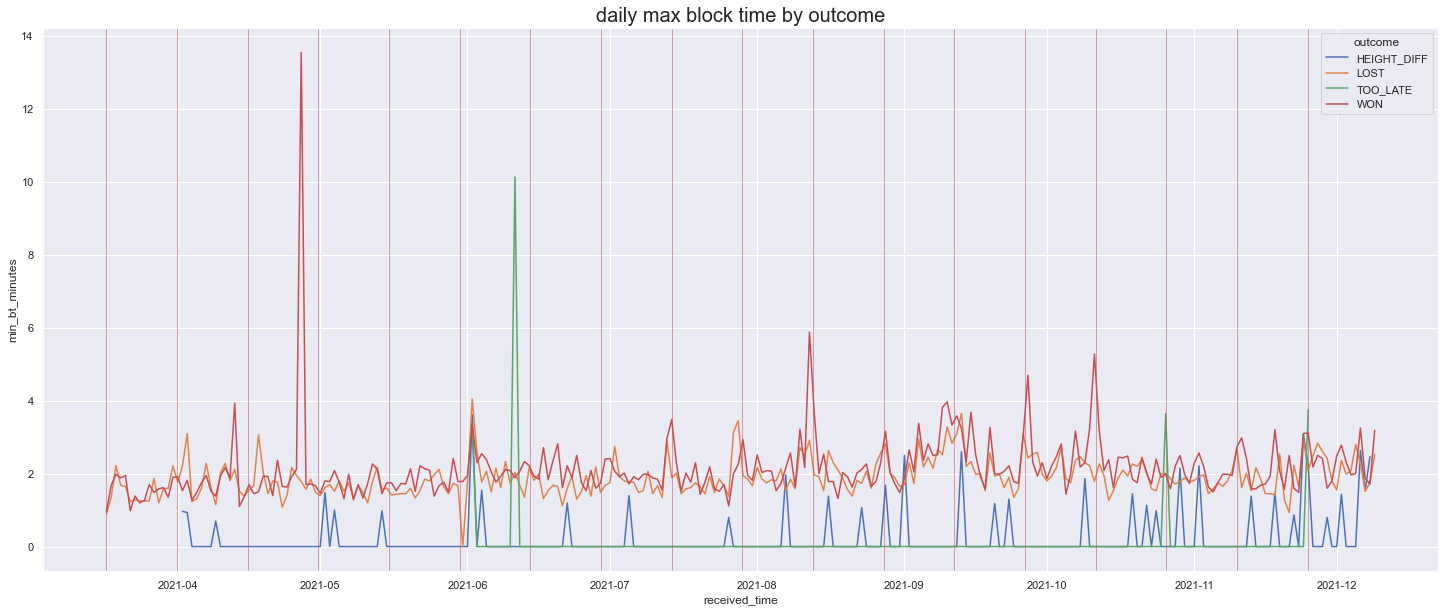

In [71]:
sns.set(rc={"figure.figsize": (25, 10)})

rt_df = tmp_df.groupby('outcome').resample('D')['min_bt_minutes'].max().reset_index()
rt_df.fillna(0, inplace=True)


f, ax = plt.subplots()
sns.lineplot(data=rt_df, x="received_time", y="min_bt_minutes", hue='outcome')
for k, v in epoch_to_start_time_dict.items():
    ax.axvline(v, 0, 1, color="r", linewidth=0.5)
ax.set_title('daily max block time by outcome', fontsize=20)

In [84]:
# only the few errors

Text(0.5, 1.0, 'max block time for each 12h slot by outcome')

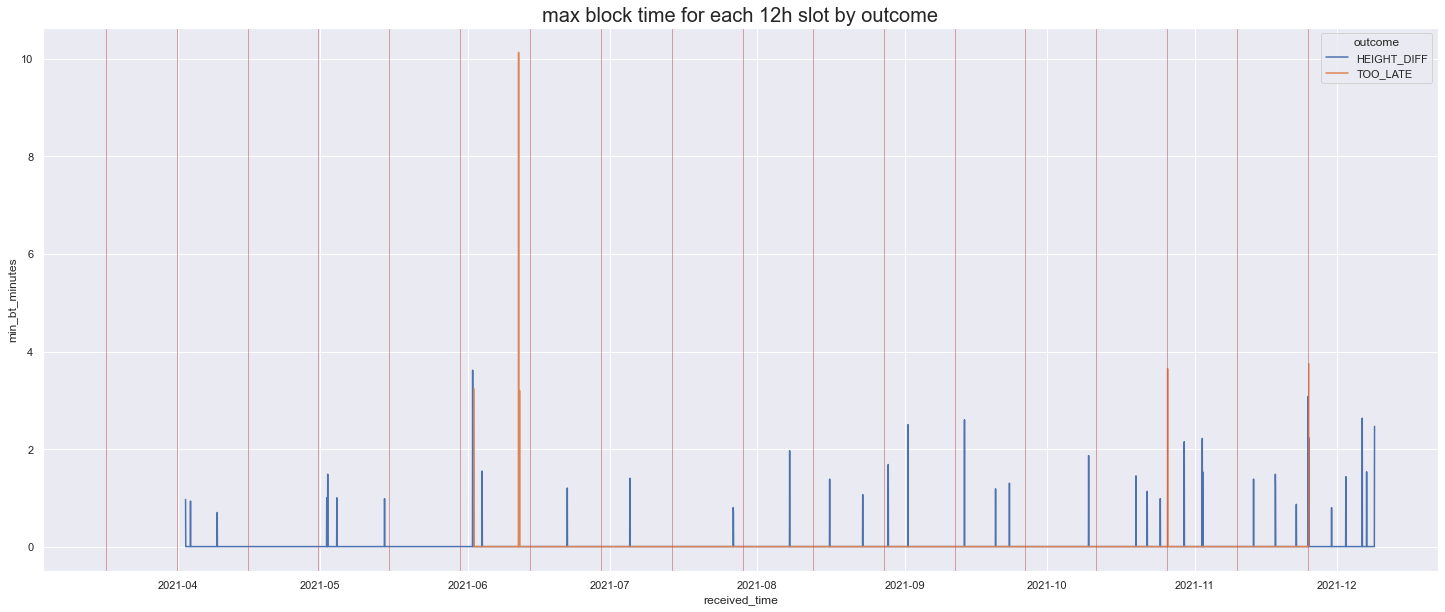

In [74]:
sns.set(rc={"figure.figsize": (25, 10)})

tmp_df = df.set_index("received_time", drop=False)
tmp_df = tmp_df[tmp_df.outcome.isin(['TOO_LATE', 'HEIGHT_DIFF'])]
rt_df = tmp_df.groupby('outcome').resample('H')['min_bt_minutes'].max().reset_index()
rt_df.fillna(0, inplace=True)

f, ax = plt.subplots()
sns.lineplot(data=rt_df, x="received_time", y="min_bt_minutes", hue='outcome')
for k, v in epoch_to_start_time_dict.items():
    ax.axvline(v, 0, 1, color="r", linewidth=0.5)
ax.set_title('max block time for each 12h slot by outcome', fontsize=20)

<AxesSubplot:xlabel='epoch', ylabel='min_bt_minutes'>

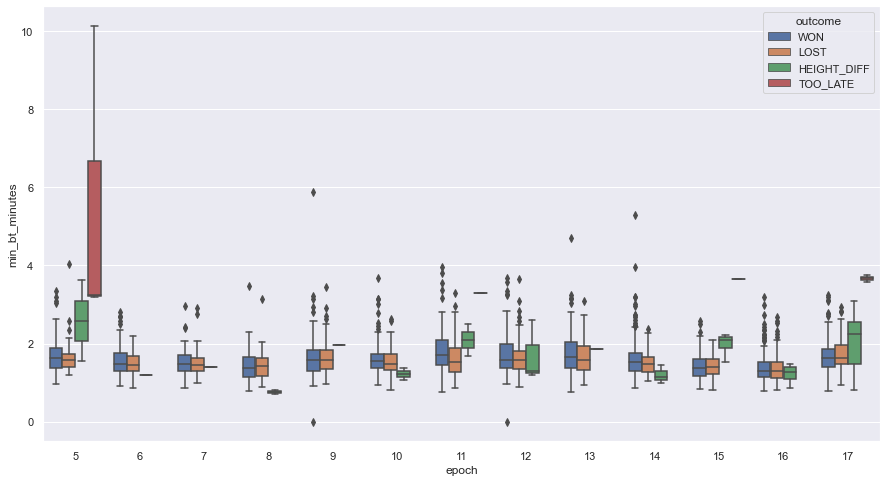

In [83]:
sns.boxplot(x="epoch", y="min_bt_minutes", data=df[df.epoch > 4], hue='outcome')